In [16]:
import pandas as pd

In [25]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [17]:
df = pd.read_csv("databases/inter/01B - dvf_sans_gps_iris_2020.csv", sep = ",", decimal = ",")
df.shape

C:\Users\olivier\anaconda\envs\Geo\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (14,27,35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(523639, 47)

In [18]:
df.columns

Index(['Unnamed: 0', 'No disposition', 'Date mutation', 'Nature mutation',
       'Valeur fonciere', 'No voie', 'B/T/Q', 'Type de voie', 'Code voie',
       'Voie', 'Code postal', 'Commune', 'Code departement', 'Code commune',
       'Prefixe de section', 'Section', 'No plan', 'No Volume', '1er lot',
       'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
       '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
       'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
       'Nombre de lots', 'Code type local', 'Type local', 'Identifiant local',
       'Surface reelle bati', 'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain', 'Code commune INSEE',
       'Ville', 'Adresse', 'Prix m2', 'Paris', 'dep_name_x', 'region_name_x',
       'dep_name_y', 'region_name_y', 'Mer'],
      dtype='object')

In [20]:
df = df[['Valeur fonciere', 'Surface reelle bati', 'Nombre pieces principales', 'Type local']]
df.head()

,Valeur fonciere,Surface reelle bati,Nombre pieces principales,Type local
0,268800.0,24.0,1.0,Appartement
1,878378.0,66.0,2.0,Appartement
2,680000.0,51.0,2.0,Appartement
3,370000.0,21.0,1.0,Appartement
4,741500.0,61.0,2.0,Appartement


In [21]:
df = df.dropna()
df.shape

(523639, 4)

In [22]:
df['Type local'] = df.apply(lambda x: 1 if x['Type local'] == "Maison" else 0, axis = 1)
df.head()

,Valeur fonciere,Surface reelle bati,Nombre pieces principales,Type local
0,268800.0,24.0,1.0,0
1,878378.0,66.0,2.0,0
2,680000.0,51.0,2.0,0
3,370000.0,21.0,1.0,0
4,741500.0,61.0,2.0,0


In [23]:
target = df['Valeur fonciere']
print(target.median())

184500.0


In [24]:
df = df.drop(columns = {'Valeur fonciere'})
df.shape

(523639, 3)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.2, random_state = 1234)

In [27]:
# Fonction d'entraînement de modèle Random Forest

def random_forest_model(X_train, X_test, y_train, y_test):
    print('X_train.shape: ', X_train.shape)
    print('X_test.shape: ', X_test.shape)
    print('y_train.shape: ', y_train.shape)
    print('y_test.shape: ', y_test.shape)
    
    regr = RandomForestRegressor(n_estimators = 50, max_depth = 500, min_samples_leaf = 5, random_state = 123)
    regr.fit(X_train, y_train)
    
    y_pred_train = regr.predict(X_train) 
    y_pred_test = regr.predict(X_test)
    
    score_train = regr.score(X_train, y_train)
    score_test = regr.score(X_test, y_test)
    rmse_train = mean_squared_error(y_pred_train, y_train, squared=False)
    rmse_test = mean_squared_error(y_pred_test, y_test, squared=False)
    mae_train = mean_absolute_error(y_pred_train, y_train)
    mae_test = mean_absolute_error(y_pred_test, y_test)
    
    results = {'score_train': score_train, 'score_test': score_test,
              'rmse_train': rmse_train, 'rmse_test': rmse_test,
              'mae_train': mae_train, 'mae_test': mae_test}

    print("score train:", score_train)
    print("score test:", score_test)

    print("rmse train : ", rmse_train)
    print('rmse test :', rmse_test)

    print("mae train : ", mae_train)
    print('mae test :', mae_test)
    
    return regr, results

In [28]:
column_list = df.columns.values

In [29]:
# Fonction de réduction de dimension de type lasso

from sklearn.linear_model import Lasso

def reduc_dim_lasso(X_train, X_test, y_train, y_test):
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lasso_r = Lasso(alpha = 1)
    lasso_r.fit(X_train, y_train)

    sel = SelectFromModel(estimator = lasso_r, threshold = 1e-10)
    sel.fit(X_train, y_train)

    mask = sel.get_support()
    plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
    plt.xlabel('Axe des features');
    plt.show();

    # Afficher un graphique représentant la valeur estimée du coefficient pour chaque variable de data
    plt.figure(figsize = (20, 10))

    lasso_coef = lasso_r.coef_ 
    plt.bar(range(len(df.columns)), lasso_coef) 
    plt.xticks(range(len(df.columns)), column_list, rotation=70);

X_train.shape:  (418911, 3)
X_test.shape:  (104728, 3)
y_train.shape:  (418911,)
y_test.shape:  (104728,)
score train: 0.2373155170000114
score test: 0.22353131731637055
rmse train :  153177.93720942608
rmse test : 153652.98686507248
mae train :  102130.07568291614
mae test : 102539.36481522079


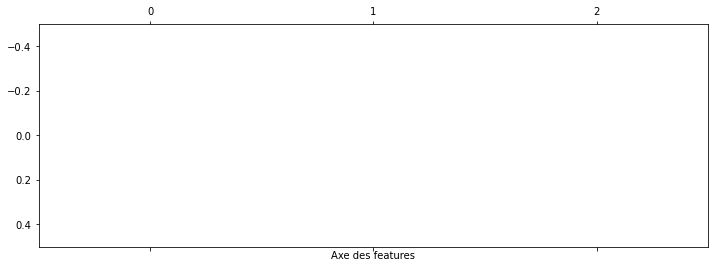

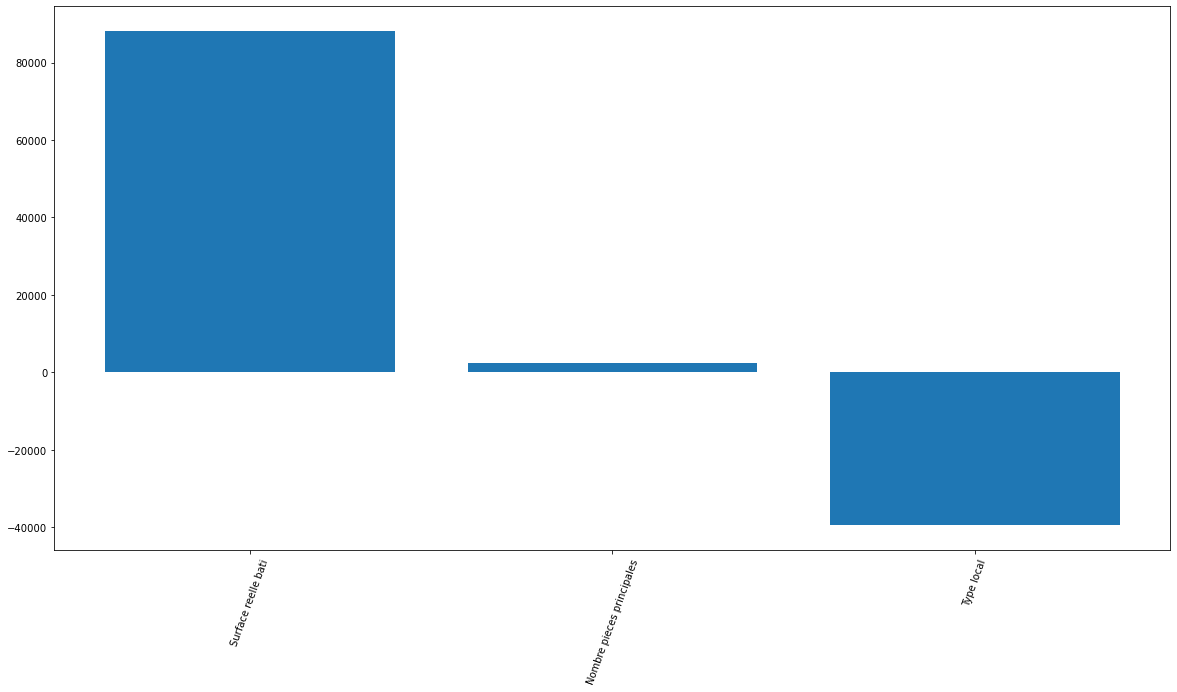

In [30]:
# Modèle global
rf_all, results_all = random_forest_model(X_train, X_test, y_train, y_test)
reduc_dim_lasso(X_train, X_test, y_train, y_test)